## 0. Getting Started <a id="importing"></a>

We'll first get our basic dependencies set up and ready to go. Since we want to use real, noisy devices for our calibration experiments in this notebook, we need to load our IBMQ account and set the appropriate backend.

In [1]:
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.pulse_v2 import draw
from qiskit import IBMQ
from utils import plot_shot_results, get_closest_multiple_of_16, save_value, load_value, load_Signal
from optimal_control import OptimalControl
gaussian_optimal_control = OptimalControl()
smooth_optimal_control = OptimalControl()
qiskit_optimal_control = OptimalControl()
paper_smooth_optimal_control = OptimalControl()
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds
    
backend_defaults = backend.defaults()

Sampling time: 0.2222222222222222 ns


Set constants and qiskit measurement equipments

In [2]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

Qubit 0 has an estimated frequency of 4.971659583238046 GHz.


In [3]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [4]:
from qiskit import pulse
from qiskit.pulse import Play
# This Pulse module helps us build sampled pulses for common pulse shapes
from qiskit.pulse import library as pulse_lib
from qiskit import assemble
from qiskit.tools.monitor import job_monitor
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [5]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [6]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

## 1. Amplitude Sweeping / define Gaussian X, Y, Z, Hadamard gates

In [227]:
def amplitude_sweep(drive_amps:np.array, Signal_list):
    schedules = []

    for drive_amp in drive_amps:
        '''rabi_pulse = pulse_lib.Constant(duration=drive_samples,
                                  amp=drive_amp,
                                  name='const_pi_pulse')'''
        this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
        for Signal in Signal_list:
            this_schedule += Play(pulse_lib.Waveform(Signal*drive_amp), drive_chan)
        # Reuse the measure instruction from the frequency sweep experiment
        this_schedule += measure << this_schedule.duration
        schedules.append(this_schedule)
        
    draw(schedules[-1], backend = backend) # is not working! (could be a problem of jupyter)
    
    from qiskit import assemble
    # Assemble the schedules into a Qobj
    num_shots_per_point = 1024

    experiment_program = assemble(schedules,
                                   backend=backend,
                                   meas_level=2,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: center_frequency_Hz}]
                                                * len(drive_amps))
    from qiskit.tools.monitor import job_monitor
    job = backend.run(experiment_program)
    job_monitor(job)
    results = job.result(timeout=120)
    plot_shot_results(job)
    return results.get_counts()

In [8]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.35
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating 


rabi_signal = np.array(pulse_lib.gaussian(duration=drive_samples, amp=1, 
                                sigma=drive_sigma).samples)

### 1.1 Gaussian X gate

Job Status: job has successfully run


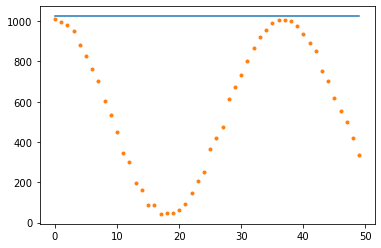

In [72]:
rabi_results = amplitude_sweep(drive_amps, [rabi_signal])

Now that we have our results, we will extract them and fit them to a sinusoidal curve. For the range of drive amplitudes we selected, we expect that we will rotate the qubit several times completely around the Bloch sphere, starting from $|0\rangle$. The amplitude of this sinusoid tells us the fraction of the shots at that Rabi drive amplitude which yielded the $|1\rangle$ state.  We want to find the drive amplitude needed for the signal to oscillate from a maximum (all $|0\rangle$ state) to a minimum (all $|1\rangle$ state) -- this gives the calibrated amplitude that enacts a $\pi$ pulse.

In [239]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

In [69]:
import matplotlib.pyplot as plt
rabi_values = []
#print(rabi_results)
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results[i]['0'])

rabi_values = np.real(baseline_remove(rabi_values))

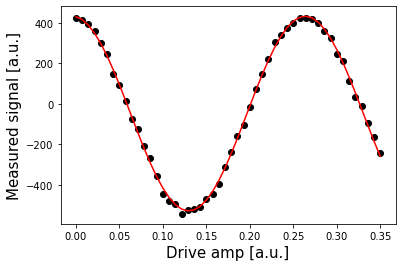

In [70]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [400, 10, 0.3, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [21]:
pi_amp = abs(drive_period / 2)
save_value("pi_amp" ,pi_amp)
print(f"Pi Amplitude = {pi_amp}")

NameError: name 'drive_period' is not defined

### Define Gates (X, Y, half pulses)
Let's define our pulse, with the amplitude we just found, so we can use it in later experiments.

In [9]:
pi_amp = load_value("pi_amp")
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

In [10]:
convert_factor = pi_amp*0.626617/(4/np.pi)/(4*1e6)
save_value('convert_factor', convert_factor)

Get other gates from gaussian X gate

In [11]:
halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp/2, 
                              sigma=drive_sigma,
                              name='halfpi_pulse')

y_pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp *1j, 
                              sigma=drive_sigma,
                              name='y_pi_pulse')

y_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp/2*1j, 
                              sigma=drive_sigma,
                              name='y_halfpi_pulse')

In [12]:
gaussian_optimal_control.gate['X']   = Play(pi_pulse, drive_chan)
gaussian_optimal_control.gate['X/2'] = Play(halfpi_pulse, drive_chan)
gaussian_optimal_control.gate['-X/2'] = Play(pulse_lib.Waveform(-halfpi_pulse.samples), drive_chan)
gaussian_optimal_control.gate['Y']   = Play(y_pi_pulse, drive_chan)
gaussian_optimal_control.gate['Y/2'] = Play(y_halfpi_pulse, drive_chan)
gaussian_optimal_control.gate['-Y/2'] = Play(pulse_lib.Waveform(-y_halfpi_pulse.samples), drive_chan)

# 2. make SOC pulses

### 2.2 SOC pulse X pi

In [98]:
convert_factor = load_value("convert_factor")
omega = np.pi/(drive_samples_us*1e-6)
#delete below code

Signal = load_Signal(omega, dt, drive_samples, "amplitudes/ours/amplitude_pi_X_x.csv", "amplitudes/ours/amplitude_pi_X_y.csv")
Signal *= convert_factor

amplitude_detuning_array = np.linspace(0.8, 1.2, 50)

Job Status: job has successfully run


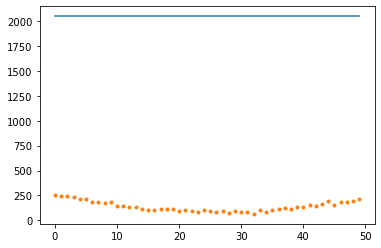

amplitude_multiplier = 1.0612244897959184


In [101]:
measure_list = amplitude_sweep(amplitude_detuning_array, [Signal])

ones = [x['1'] for x in measure_list]
amplitude_multiplier_SOC_pi = amplitude_detuning_array[np.argmax(ones)]
print("amplitude_multiplier = {}".format(amplitude_multiplier_SOC_pi))

save_value("amplitude_multiplier_SOC_pi", amplitude_multiplier_SOC_pi)

In [103]:
amplitude_multiplier_SOC_pi = load_value("amplitude_multiplier_SOC_pi")

pulse_SOC_pi_X = pulse.Waveform(Signal*amplitude_multiplier_SOC_pi)
pulse_SOC_pi_Y = pulse.Waveform(Signal*amplitude_multiplier_SOC_pi*1j)

smooth_optimal_control.gate['X'] = Play(pulse_SOC_pi_X, drive_chan)
smooth_optimal_control.gate['Y'] = Play(pulse_SOC_pi_Y, drive_chan)

### SOC pulse X pi/2

In [110]:
convert_factor = load_value('convert_factor')
omega = np.pi/(drive_samples_us*1e-6)
#delete below code

Signal = load_Signal(omega, dt, drive_samples, "amplitudes/ours/amplitude_pi_over_2_X_x.csv", "amplitudes/ours/amplitude_pi_over_2_X_y.csv")
Signal *= convert_factor
amplitude_detuning_array = np.linspace(0.95, 1.1, 50)

Job Status: job has successfully run


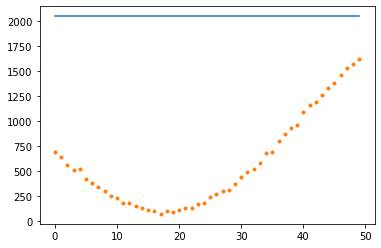

In [111]:
measure_list = amplitude_sweep(amplitude_detuning_array, [Signal, Signal])

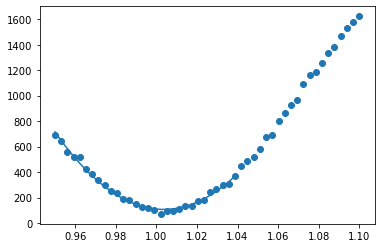

amplitude_multiplier = 1.0036136516677678


In [112]:
fit_params, y_fit = fit_function(amplitude_detuning_array[:30],
                                 [x['0'] for x in measure_list][:30], 
                                 lambda x, A, B, C: (A*(x-B)**2 + C),
                                 [100000, 1, 0])

from matplotlib import pyplot as plt
plt.scatter(amplitude_detuning_array, [x['0'] for x in measure_list])
plt.plot(amplitude_detuning_array[:30], y_fit)
plt.show()

amplitude_multiplier_SOC_pi_over_2 = fit_params[1]
print("amplitude_multiplier = {}".format(amplitude_multiplier_SOC_pi_over_2))

save_value("amplitude_multiplier_SOC_pi_over_2", amplitude_multiplier_SOC_pi_over_2)

In [113]:
amplitude_multiplier_SOC_pi_over_2 = load_value('amplitude_multiplier_SOC_pi_over_2')

pulse_SOC_pi_over_2_X = pulse.Waveform(Signal*amplitude_multiplier_SOC_pi_over_2)
pulse_SOC_pi_over_2_Y = pulse.Waveform(Signal*amplitude_multiplier_SOC_pi_over_2*1j)

smooth_optimal_control.gate['X/2'] = Play(pulse_SOC_pi_over_2_X, drive_chan)
smooth_optimal_control.gate['-X/2'] = Play(pulse_lib.Waveform(-pulse_SOC_pi_over_2_X.samples), drive_chan)
smooth_optimal_control.gate['Y/2'] = Play(pulse_SOC_pi_over_2_Y, drive_chan)
smooth_optimal_control.gate['-Y/2'] = Play(pulse_lib.Waveform(-pulse_SOC_pi_over_2_Y.samples), drive_chan)

## make qiskit pulse

In [ ]:
from qiskit import QuantumCircuit
from qiskit import transpile, schedule as build_schedule
from qiskit.circuit.library import UGate
# x
x_circ = QuantumCircuit(1, 1)
x_circ.x(0)
x_circ = transpile(x_circ, backend)
x_schedule = build_schedule(x_circ, backend)

# y
y_circ = QuantumCircuit(1, 1)
y_circ.y(0)
y_circ = transpile(y_circ, backend)
y_schedule = build_schedule(y_circ, backend)

# y halfpi
xh_circ = QuantumCircuit(1, 1)
xh_circ.h(0)
xh_circ.x(0)
backend = backend
xh_circ = transpile(xh_circ, backend)
xh_schedule = build_schedule(xh_circ, backend)

#minus y halfpi
zh_circ = QuantumCircuit(1, 1)
zh_circ.h(0)
zh_circ.z(0)
zh_circ = transpile(zh_circ, backend)
zh_schedule = build_schedule(zh_circ, backend)

# minus x_half pi
shs_circ = QuantumCircuit(1, 1)
shs_circ.s(0)
shs_circ.h(0)
shs_circ.s(0)
shs_circ = transpile(shs_circ, backend)
shs_schedule = build_schedule(shs_circ, backend)
# x_half pi
xshs_circ = QuantumCircuit(1, 1)
xshs_circ.s(0)
xshs_circ.h(0)
xshs_circ.s(0)
xshs_circ.x(0)
xshs_circ = transpile(xshs_circ, backend)
xshs_schedule = build_schedule(xshs_circ, backend)

qiskit_optimal_control.gate['X'] = x_schedule
qiskit_optimal_control.gate['Y'] = y_schedule
qiskit_optimal_control.gate['Y/2'] = xh_schedule
qiskit_optimal_control.gate['X/2'] = xshs_schedule
qiskit_optimal_control.gate['-X/2'] = shs_schedule
qiskit_optimal_control.gate['-Y/2'] = zh_schedule

## make paper_SOC pulses

In [289]:
convert_factor = load_value('convert_factor')
drive_samples = int(500e-9/dt)
omega = np.pi/(500*1e-9)
#delete below code
drive_samples = get_closest_multiple_of_16(drive_samples)

Signal = load_Signal(omega, dt, drive_samples, "amplitudes/paper/amplitude_pi_X_x.csv", "amplitudes/paper/amplitude_pi_X_y.csv")
Signal *= 1e6 * convert_factor
amplitude_detuning_array = np.linspace(3.,8, 50)

Job Status: job has successfully run


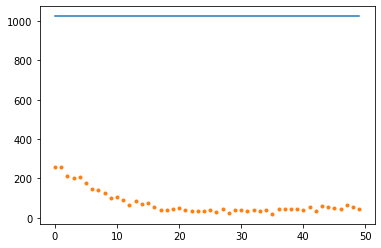

In [180]:
measure_list = amplitude_sweep(amplitude_detuning_array, [Signal])

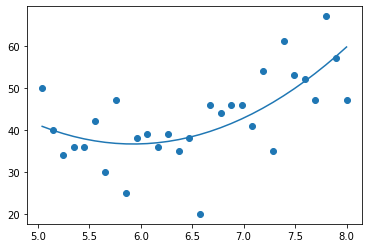

amplitude_multiplier = 5.925646643742295


In [186]:
fit_params, y_fit = fit_function(amplitude_detuning_array[20:],
                                 [x['0'] for x in measure_list][20:], 
                                 lambda x, A, B, C: (A*(x-B)**2 + C),
                                 [100000, 1, 0])

from matplotlib import pyplot as plt
plt.scatter(amplitude_detuning_array[20:], [x['0'] for x in measure_list][20:])
plt.plot(amplitude_detuning_array[20:], y_fit)
plt.show()

amplitude_multiplier_paper_SOC = fit_params[1]
print("amplitude_multiplier = {}".format(amplitude_multiplier_paper_SOC))
save_value("amplitude_multiplier_paper_SOC", amplitude_multiplier_paper_SOC)

In [273]:
def angle_sweep_pi(angles, Signal_list):
    drive_amps = np.exp(angles*1j)
    schedules = []

    for drive_amp in drive_amps:
        '''rabi_pulse = pulse_lib.Constant(duration=drive_samples,
                                  amp=drive_amp,
                                  name='const_pi_pulse')'''
        this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
        this_schedule += qiskit_optimal_control.gate['X/2']
        for Signal in Signal_list:
            this_schedule += Play(pulse_lib.Waveform(Signal*drive_amp), drive_chan)
        # Reuse the measure instruction from the frequency sweep experiment
        this_schedule += qiskit_optimal_control.gate['X/2']
        this_schedule += measure << this_schedule.duration
        schedules.append(this_schedule)
        
    draw(schedules[-1], backend = backend) # is not working! (could be a problem of jupyter)
    
    from qiskit import assemble
    # Assemble the schedules into a Qobj
    num_shots_per_point = 1024

    experiment_program = assemble(schedules,
                                   backend=backend,
                                   meas_level=2,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: center_frequency_Hz}]
                                                * len(drive_amps))
    from qiskit.tools.monitor import job_monitor
    job = backend.run(experiment_program)
    job_monitor(job)
    results = job.result(timeout=120)
    plot_shot_results(job)
    return results.get_counts()

Job Status: job has successfully run


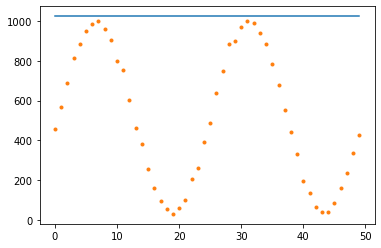

In [279]:
angles = np.linspace(0, 2*np.pi, 50)
measure_list = angle_sweep_pi(angles, [Signal*amplitude_multiplier_paper_SOC])

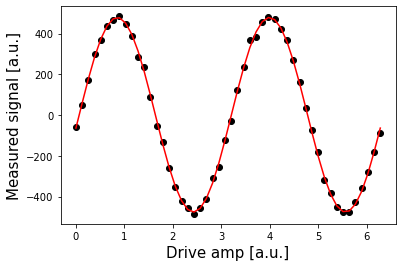

In [283]:
angles = np.linspace(0, 2*np.pi, 50)
values = baseline_remove([x['0'] for x in measure_list])
fit_params, y_fit = fit_function(angles,
                                 values, 
                                 lambda x, A, B, phi: (A*np.cos(x*2 - phi) + B),
                                 [490, 0.8, 0])

plt.scatter(angles, values, color='black')
plt.plot(angles, y_fit, color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [290]:
paper_SOC_pi_angle = fit_params[2]/2
save_value("paper_SOC_pi_angle", paper_SOC_pi_angle)

In [293]:
amplitude_multiplier_paper_SOC = load_value('amplitude_multiplier_paper_SOC')
angle = load_value('paper_SOC_pi_angle')

Signal_final = Signal * amplitude_multiplier_paper_SOC * np.exp(angle * 1j)

pulse_paper_SOC_pi_X = pulse.Waveform(Signal_final)
pulse_paper_SOC_pi_Y = pulse.Waveform(Signal_final*1j)

paper_smooth_optimal_control.gate['X'] = Play(pulse_paper_SOC_pi_X, drive_chan)
paper_smooth_optimal_control.gate['Y'] = Play(pulse_paper_SOC_pi_Y, drive_chan)

In [287]:
convert_factor = load_value('convert_factor')
drive_samples = int(250e-9/dt)
omega = np.pi/(250*1e-9)
#delete below code
drive_samples = get_closest_multiple_of_16(drive_samples)

Signal = load_Signal(omega, dt, drive_samples, "amplitudes/paper/amplitude_pi_over_2_X_x.csv", "amplitudes/paper/amplitude_pi_over_2_X_y.csv")
Signal *= 1e6 * convert_factor
amplitude_detuning_array = np.linspace(1.2,2.1, 20)

Job Status: job has successfully run


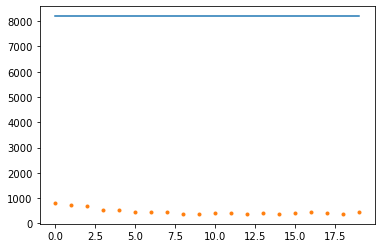

In [214]:
measure_list = amplitude_sweep(amplitude_detuning_array, [Signal, Signal])

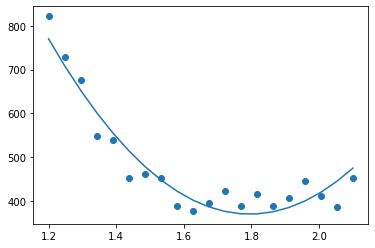

amplitude_multiplier = 1.7951741580682021


In [215]:
fit_params, y_fit = fit_function(amplitude_detuning_array[:],
                                 [x['0'] for x in measure_list][:], 
                                 lambda x, A, B, C: (A*(x-B)**2 + C),
                                 [100000, 1, 0])

from matplotlib import pyplot as plt
plt.scatter(amplitude_detuning_array[:], [x['0'] for x in measure_list][:])
plt.plot(amplitude_detuning_array[:], y_fit)
plt.show()

amplitude_multiplier_paper_SOC_pi_over_2 = fit_params[1]
print("amplitude_multiplier = {}".format(amplitude_multiplier_paper_SOC_pi_over_2))
save_value("amplitude_multiplier_paper_SOC_pi_over_2", amplitude_multiplier_paper_SOC_pi_over_2)

In [236]:
def angle_sweep_pi_over_2(angles, Signal_list):
    drive_amps = np.exp(angles*1j)
    schedules = []

    for drive_amp in drive_amps:
        '''rabi_pulse = pulse_lib.Constant(duration=drive_samples,
                                  amp=drive_amp,
                                  name='const_pi_pulse')'''
        this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
        this_schedule += qiskit_optimal_control.gate['X/2']
        for Signal in Signal_list:
            this_schedule += Play(pulse_lib.Waveform(Signal*drive_amp), drive_chan)
        # Reuse the measure instruction from the frequency sweep experiment
        this_schedule += measure << this_schedule.duration
        schedules.append(this_schedule)
        
    draw(schedules[-1], backend = backend) # is not working! (could be a problem of jupyter)
    
    from qiskit import assemble
    # Assemble the schedules into a Qobj
    num_shots_per_point = 1024

    experiment_program = assemble(schedules,
                                   backend=backend,
                                   meas_level=2,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: center_frequency_Hz}]
                                                * len(drive_amps))
    from qiskit.tools.monitor import job_monitor
    job = backend.run(experiment_program)
    job_monitor(job)
    results = job.result(timeout=120)
    plot_shot_results(job)
    return results.get_counts()

Job Status: job has successfully run


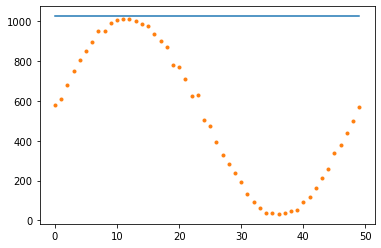

In [237]:
angles = np.linspace(0, 2*np.pi, 50)
measure_list = angle_sweep_pi_over_2([Signal*amplitude_multiplier_paper_SOC_pi_over_2], angles)

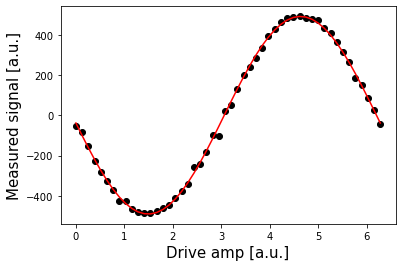

In [264]:
angles = np.linspace(0, 2*np.pi, 50)
values = baseline_remove([x['1'] for x in measure_list])
fit_params, y_fit = fit_function(angles,
                                 values, 
                                 lambda x, A, B, phi: (A*np.cos(x - phi) + B),
                                 [490, 0.8, 0])

plt.scatter(angles, values, color='black')
plt.plot(angles, y_fit, color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [267]:
paper_SOC_pi_over_2_angle = fit_params[2]
save_value("paper_SOC_pi_over_2_angle", paper_SOC_pi_over_2_angle)

In [268]:
amplitude_multiplier_paper_SOC_pi_over_2 = load_value('amplitude_multiplier_paper_SOC_pi_over_2')
paper_SOC_pi_over_2_angle = load_value('paper_SOC_pi_over_2_angle')
Signal_final = Signal * amplitude_multiplier_paper_SOC_pi_over_2 * np.exp(paper_SOC_pi_over_2_angle*1j)
pulse_paper_SOC_pi_X_over_2 = pulse.Waveform(Signal_final)
pulse_paper_SOC_pi_Y_over_2 = pulse.Waveform(Signal_final*1j)
pulse_paper_SOC_pi_m_X_over_2 = pulse.Waveform(-Signal_final)
pulse_paper_SOC_pi_m_Y_over_2 = pulse.Waveform(-Signal_final*1j)

paper_smooth_optimal_control.gate['X/2'] = Play(pulse_paper_SOC_pi_X_over_2, drive_chan)
paper_smooth_optimal_control.gate['Y/2'] = Play(pulse_paper_SOC_pi_Y_over_2, drive_chan)
paper_smooth_optimal_control.gate['-X/2'] = Play(pulse_paper_SOC_pi_m_X_over_2, drive_chan)
paper_smooth_optimal_control.gate['-Y/2'] = Play(pulse_paper_SOC_pi_m_Y_over_2, drive_chan)

## make qiskit pulses

## Compare frequency detuning

In [89]:
def frequency_sweep(pulse_list : list):
    frequency_span_Hz = 4 * MHz
    frequency_step_Hz = 0.1 * MHz

    # We will sweep 20 MHz above and 20 MHz below the estimated frequency
    frequency_min = center_frequency_Hz - frequency_span_Hz / 2
    frequency_max = center_frequency_Hz + frequency_span_Hz / 2
    # Construct an np array of the frequencies for our experiment
    frequencies_GHz = np.arange(frequency_min / GHz, 
                                frequency_max / GHz, 
                                frequency_step_Hz / GHz)

    print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
    in steps of {frequency_step_Hz / MHz} MHz.")
    
    
    # Create the base schedule
    # Start with drive pulse acting on the drive channel
    schedule = pulse.Schedule(name='Frequency sweep')
    for p in pulse_list:
        schedule += p
    # The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
    schedule += measure << schedule.duration

    # Create the frequency settings for the sweep (MUST BE IN HZ)
    frequencies_Hz = frequencies_GHz*GHz
    schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]
    
    from qiskit import assemble
    num_shots_per_frequency = 1024
    pi_frequency_sweep_program = assemble(schedule,
                                       backend=backend, 
                                       meas_level=2,
                                       meas_return='avg',
                                       shots=num_shots_per_frequency,
                                       schedule_los=schedule_frequencies)
    job = backend.run(pi_frequency_sweep_program)
    job_monitor(job)
    plot_shot_results(job)

The sweep will go from 4.9696595832380455 GHz to 4.973659583238046 GHz     in steps of 0.1 MHz.
Job Status: job has successfully run


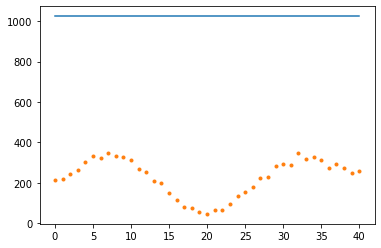

The sweep will go from 4.9696595832380455 GHz to 4.973659583238046 GHz     in steps of 0.1 MHz.
Job Status: job has successfully run


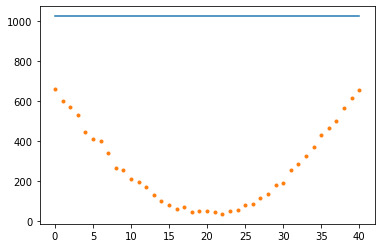

In [104]:
frequency_sweep([smooth_optimal_control.gate['X']])
frequency_sweep([gaussian_optimal_control.gate['X']])

The sweep will go from 4.9696595832380455 GHz to 4.973659583238046 GHz     in steps of 0.1 MHz.
Job Status: job has successfully run


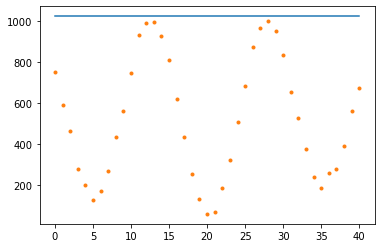

The sweep will go from 4.9696595832380455 GHz to 4.973659583238046 GHz     in steps of 0.1 MHz.
Job Status: job has successfully run


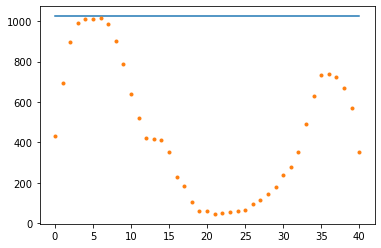

In [97]:
frequency_sweep(gaussian_optimal_control.make_pulse_list(['X/2', 'X/2']))
frequency_sweep(smooth_optimal_control.make_pulse_list(['X/2','X/2']))

### check paper's results

The sweep will go from 4.9696595832380455 GHz to 4.973659583238046 GHz     in steps of 0.1 MHz.
Job Status: job has successfully run


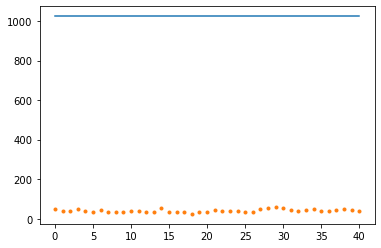

In [152]:
frequency_sweep([paper_smooth_optimal_control.gate['X']])

The sweep will go from 4.9696595832380455 GHz to 4.973659583238046 GHz     in steps of 0.1 MHz.
Job Status: job has successfully run


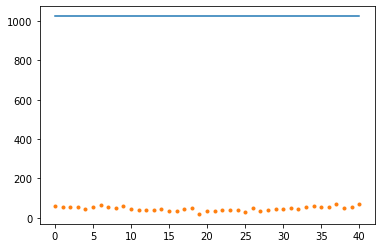

In [95]:
frequency_sweep([qiskit_optimal_control.gate['X']])

## 3. Calculate state fidelity function

From now, we can calculate state fidelity using above optimal control gates. State tomography is skipped in this notebook. However it's functions are useful to calculate process tomography.

In [20]:
def calculate_state_fidelity(x_expect_val, y_expect_val, z_expect_val, target_state_vector):
    pauli_x = np.array([[0,1],[1,0]])
    pauli_y = np.array([[0,-1j],[1j,0]])
    pauli_z = np.array([[1,0],[0,-1]])
    density_matrix = 1/2 * (np.identity(2) + x_expect_val * pauli_x + y_expect_val * pauli_y + z_expect_val * pauli_z)
    print(density_matrix)
    fidelity = np.dot(target_state_vector.conjugate(), density_matrix@(target_state_vector))
    print(fidelity)
    return fidelity

In [21]:
def get_expectation_value_with_detuning(schedule, detuning, num = 1, execute = True):
    num_shots_per_point = 1024
    new_Freq = center_frequency_Hz + detuning
    program = assemble(schedule,backend=backend,meas_level=2,meas_return='avg',shots=num_shots_per_point,schedule_los=[{drive_chan: new_Freq}]*num)

    if execute:
        job = backend.run(program)
        job_monitor(job)
    results = job.result(timeout=120)
    measure_list = results.get_counts()
    print(measure_list)
    if num ==1:
        expectation_value = (measure_list['0'] * 1 + measure_list['1'] * (-1)) / (measure_list['0'] + measure_list['1'])
    else:
        expectation_value = (measure_list[-1]['0'] * 1 + measure_list[-1]['1'] * (-1)) / (measure_list[-1]['0'] + measure_list[-1]['1'])
    return expectation_value

## 4. Process Tomography of the optimal control pulses

### 4.1. Util functions

In [22]:
from scipy.linalg import solve

In [23]:
pauli_x = np.array([[0,1],[1,0]])
pauli_y = np.array([[0,-1j],[1j,0]])
pauli_z = np.array([[1,0],[0,-1]])
basis_matrices = np.array([np.identity(2), pauli_x, -1j*pauli_y,pauli_z])
initial_density_matrices = np.array([np.array([[1,0]]).transpose()@np.array([[1,0]]).conjugate(),\
                                    np.array([[0,1]]).transpose()@np.array([[0,1]]).conjugate(),\
                                    1/2*np.array([[1,1]]).transpose()@np.array([[1,1]]).conjugate(),\
                                    1/2*np.array([[1,1j]]).transpose()@np.array([[1,1j]]).conjugate()])

inverse_initial_density_matrices = np.linalg.inv(initial_density_matrices.transpose(1,2,0).reshape((4,4),order = 'F')).transpose()
'''
beta_coefficients = np.zeros((4,4,4,4), dtype = 'complex64')
for j in range(4):
    beta_coefficients[j] = np.linalg.inv(initial_density_matrices.transpose(1,2,0).reshape(4,4))\
                           @ (np.einsum('mio,jok,nlk->jmnil',basis_matrices, initial_density_matrices, basis_matrices.conjugate()))[j].reshape(4,4,4)
beta_coefficients = beta_coefficients.transpose(0,3,1,2)
'''
print(inverse_initial_density_matrices)
inverse_initial_density_matrices[1,0]

[[ 1. +0.j   0. +0.j   0. +0.j   0. +0.j ]
 [-0.5+0.5j -0.5+0.5j  1. +0.j   0. -1.j ]
 [-0.5-0.5j -0.5-0.5j  1. +0.j   0. +1.j ]
 [ 0. +0.j   1. +0.j   0. +0.j   0. +0.j ]]


(-0.5+0.5j)

In [24]:
def density_matrix(x_expect_val, y_expect_val, z_expect_val):
    density_matrix = 1/2 * (np.identity(2) + x_expect_val * pauli_x + y_expect_val * pauli_y + z_expect_val * pauli_z)
    print(density_matrix)
    return density_matrix

In [25]:
def calculate_process_matrix(density_matrices):
    id2 = np.identity(2)
    transformed_matrices = (inverse_initial_density_matrices@density_matrices.reshape(4,4)).transpose().reshape((4,2,2), order = 'F')
    '''
    transformed_matrices = np.zeros((4,2,2), dtype = 'complex64')
    for i in range(4):
        for j in range(4):
            transformed_matrices[i,:,:] += (inverse_initial_density_matrices[i,j] * density_matrices[j])
    
    '''
    process_matrix = 1/4 * (np.vstack((np.hstack((id2, pauli_x)), np.hstack((pauli_x, -id2))))@\
    np.vstack((np.hstack((transformed_matrices[0], transformed_matrices[1])), np.hstack((transformed_matrices[2], transformed_matrices[3]))))@\
    np.vstack((np.hstack((id2, pauli_x)), np.hstack((pauli_x, -id2)))))
    return process_matrix

In [26]:
def process_matrix_error(t,*process_matrix):
    t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11, t12, t13, t14, t15, t16 = t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8], t[9], t[10], t[11], t[12], t[13], t[14], t[15]
    T = np.array([[t1, 0, 0, 0],[t5 + 1j*t6, t2, 0, 0],[t11 + 1j*t12, t7+ 1j*t8, t3, 0],[t15 + 1j*t16, t13 + 1j*t14, t9 + 1j*t10, t4]], dtype = np.complex64)
    new_process_matrix = T.conjugate().transpose()@T
    matrix_error = process_matrix - new_process_matrix
    return np.sqrt(np.trace(matrix_error@(matrix_error.conjugate().transpose())))

In [27]:
from scipy.optimize import dual_annealing
def adjust_process_matrix(process_matrix):
    lw = [-5] * 16
    up = [5] * 16
    ret = dual_annealing(process_matrix_error, args = (process_matrix), bounds=list(zip(lw, up)))
    t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11, t12, t13, t14, t15, t16 = ret.x[0], ret.x[1], ret.x[2], ret.x[3], ret.x[4], ret.x[5], ret.x[6], ret.x[7], ret.x[8], ret.x[9], ret.x[10], ret.x[11], ret.x[12], ret.x[13], ret.x[14], ret.x[15]
    T = np.array([[t1, 0, 0, 0],[t5 + 1j*t6, t2, 0, 0],[t11 + 1j*t12, t7+ 1j*t8, t3, 0],[t15 + 1j*t16, t13 + 1j*t14, t9 + 1j*t10, t4]], dtype = np.complex64)
    new_process_matrix = (T.conjugate().transpose())@T
    return new_process_matrix

In [28]:
def calculate_fidelity(target_matrix, process_matrix):
    id2 = np.eye(2)
    mat = 1/2 * (np.vstack((np.hstack((id2, pauli_x)), np.hstack((pauli_x, -id2)))))
    beta = np.kron(mat, mat)
    print(beta.shape)
    #Re(Tr (U(tf )†Ud))
calculate_fidelity(pauli_x, pauli_x)

(16, 16)


### 4.2 Tomography functions

In [30]:
def x_expect_schedule(schedule, oc_gate):
    schedule += oc_gate['-Y/2']
    schedule += measure << schedule.duration
    return schedule
    #return get_expectation_value_with_detuning(schedule, detuninig)

def y_expect_schedule(schedule, oc_gate):
    schedule += oc_gate['X/2']
    schedule += measure << schedule.duration
    return schedule
    # -get_expectation_value_with_detuning(schedule, detuninig)

def z_expect_schedule(schedule, oc_gate):
    schedule += measure << schedule.duration
    return schedule
    # return get_expectation_value_with_detuning(schedule, detuninig)

In [31]:
def initialized_schedule(init_state, oc_gate):
    schedule = pulse.Schedule()
    if init_state == '0':
        pass
    elif init_state == '1':
        schedule += oc_gate['X']
    elif init_state == '+':
        schedule += oc_gate['Y/2']
    elif init_state == '-':
        schedule += oc_gate['-X/2']
    else:
        assert "init_state is not stated in this function"
    return schedule

In [32]:
# objective_gate is an obective gate to calculate gate fidelity
# oc_gate is a category(smooth_optimal_control or gaussian_optimal_control ...) of base gates(ex X, Y, X/2, etc.)
import copy
def get_xyz_schedules(objective_gate, oc_gate, init_state):
    schedule = pulse.Schedule()
    schedule_init = initialized_schedule(init_state, oc_gate)
    schedule_init += objective_gate
    x_schedule = x_expect_schedule(copy.deepcopy(schedule_init), oc_gate)
    z_schedule = z_expect_schedule(copy.deepcopy(schedule_init), oc_gate)
    y_schedule = y_expect_schedule(copy.deepcopy(schedule_init), oc_gate)
    return [x_schedule, y_schedule, z_schedule]
    

In [33]:
def get_density_matrices_from_schedules(pi_xyz_schedules, detuning):
    schedules = np.array(pi_xyz_schedules).flatten().tolist()
    
    draw(schedules[-1], backend = backend) # is not working! (could be a problem of jupyter)
    
    from qiskit import assemble
    # Assemble the schedules into a Qobj
    num_shots_per_point = 1024

    experiment_program = assemble(schedules,
                                   backend=backend,
                                   meas_level=2,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: center_frequency_Hz + detuning}]
                                                * len(schedules))
    from qiskit.tools.monitor import job_monitor
    job = backend.run(experiment_program)
    job_monitor(job)
    results = job.result(timeout=120)
    measure_list = results.get_counts()
    expectation_values_list = [(M['0'] * 1 + M['1'] * (-1)) / (M['0'] + M['1']) for M in measure_list]
    expectation_values_array = np.array(expectation_values_list).reshape(4, 3)
    density_matrices = [density_matrix(expectation[0], expectation[1], expectation[2]) for expectation in expectation_values_array]
    return np.array(density_matrices)

In [34]:
def gate_tomography(objective_gate, oc_gate, detuning):
    density_matrice_results = {}
    init_states = ['0', '1', '+', '-']
    xyz_schedules = [get_xyz_schedules(objective_gate, oc_gate, init_state) for init_state in init_states]
    pi_density_matrices = get_density_matrices_from_schedules(xyz_schedules, detuning)
    pi_process_matrix = calculate_process_matrix(pi_density_matrices)
    adjust_process_matrix(pi_process_matrix)
    return pi_process_matrix

In [35]:
def plot_density_matrix(data_array):
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x_data, y_data = np.meshgrid( np.arange(4),
                                  np.arange(4))
    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = data_array.flatten()
    ax.bar3d( x_data,
              y_data,
              0.5*np.zeros(len(z_data)),
              0.8, 0.8, z_data )
    #
    # Finally, display the plot.
    #
    plt.show()


    # Construct arrays with the dimensions for the 16 bars.

### Tomography results

C:\Users\jhhop\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.


Job Status: job has successfully run
[[0.03417969+0.j         0.05371094-0.09863281j]
 [0.05371094+0.09863281j 0.96582031+0.j        ]]
[[ 0.97753906+0.j         -0.00976562+0.14160156j]
 [-0.00976562-0.14160156j  0.02246094+0.j        ]]
[[0.58496094+0.j         0.48046875-0.06152344j]
 [0.48046875+0.06152344j 0.41503906+0.j        ]]
[[0.48046875+0.j         0.04589844+0.45703125j]
 [0.04589844-0.45703125j 0.51953125+0.j        ]]


C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\optimize.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = df
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\lbfgsb.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  isave, dsave, maxls)


[[ 0.02563477+0.j          0.01098633-0.07275391j  0.02368164-0.01074219j
   0.00292969+0.02954102j]
 [ 0.01098633+0.07275391j  0.93286133+0.j          0.00292969+0.0534668j
   0.05541992-0.01074219j]
 [ 0.02368164+0.01074219j  0.00292969-0.0534668j   0.03881836+0.j
  -0.01098633-0.04736328j]
 [ 0.00292969-0.02954102j  0.05541992+0.01074219j -0.01098633+0.04736328j
   0.00268555+0.j        ]]


C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:2428: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


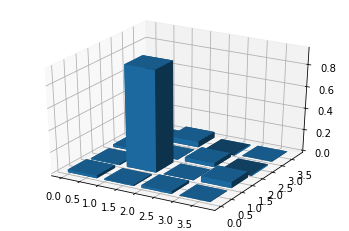

In [36]:
pi_process_matrix = gate_tomography(gaussian_optimal_control.gate['X'], gaussian_optimal_control.gate, detuning = 0)
print(pi_process_matrix)
plot_density_matrix(pi_process_matrix)

Job Status: job has successfully run
[[0.25683594+0.j        0.32226562-0.1953125j]
 [0.32226562+0.1953125j 0.74316406+0.j       ]]
[[ 0.30175781+0.j         -0.20898438+0.36816406j]
 [-0.20898438-0.36816406j  0.69824219+0.j        ]]
[[0.65722656+0.j         0.34960938+0.28515625j]
 [0.34960938-0.28515625j 0.34277344+0.j        ]]
[[ 0.14355469+0.j         -0.05371094+0.27246094j]
 [-0.05371094-0.27246094j  0.85644531+0.j        ]]


C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\optimize.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = df
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\lbfgsb.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  isave, dsave, maxls)
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:2428: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


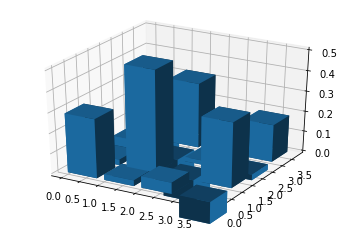

In [116]:
pi_process_matrix = gate_tomography(smooth_optimal_control.gate['X'], smooth_optimal_control.gate, detuning = 1*MHz)
plot_density_matrix(pi_process_matrix)

Job Status: job has successfully run
[[0.19335938+0.j       0.29785156+0.140625j]
 [0.29785156-0.140625j 0.80664062+0.j      ]]
[[ 0.40820312+0.j         -0.4140625 -0.21289062j]
 [-0.4140625 +0.21289062j  0.59179688+0.j        ]]
[[0.79003906+0.j         0.453125  -0.10351562j]
 [0.453125  +0.10351562j 0.20996094+0.j        ]]
[[0.57519531+0.j         0.08007812+0.43066406j]
 [0.08007812-0.43066406j 0.42480469+0.j        ]]


C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\optimize.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = df
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\lbfgsb.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  isave, dsave, maxls)
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:2428: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


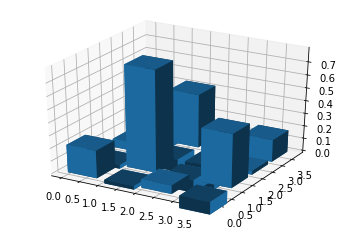

In [221]:
pi_process_matrix = gate_tomography(gaussian_optimal_control.gate['X'], gaussian_optimal_control.gate, detuning = 1 * MHz)
plot_density_matrix(pi_process_matrix)

Job Status: job has successfully run
[[ 0.09179688+0.j         -0.11816406-0.21582031j]
 [-0.11816406+0.21582031j  0.90820312+0.j        ]]
[[ 0.93847656+0.j         -0.08398438+0.08300781j]
 [-0.08398438-0.08300781j  0.06152344+0.j        ]]
[[0.39160156+0.j         0.45507812-0.04882812j]
 [0.45507812+0.04882812j 0.60839844+0.j        ]]
[[ 0.27539062+0.j         -0.02832031+0.41308594j]
 [-0.02832031-0.41308594j  0.72460938+0.j        ]]


C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\optimize.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = df
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\lbfgsb.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  isave, dsave, maxls)
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:2428: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


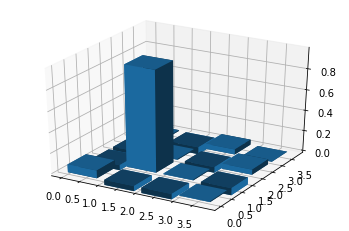

In [226]:
pi_process_matrix = gate_tomography(qiskit_optimal_control.gate['X'], qiskit_optimal_control.gate, detuning = 3*MHz)
plot_density_matrix(pi_process_matrix)

Job Status: job has successfully run
[[0.03613281+0.j        0.03808594+0.0390625j]
 [0.03808594-0.0390625j 0.96386719+0.j       ]]
[[ 0.97949219+0.j         -0.046875  -0.04980469j]
 [-0.046875  +0.04980469j  0.02050781+0.j        ]]
[[0.53027344+0.j         0.48730469-0.03027344j]
 [0.48730469+0.03027344j 0.46972656+0.j        ]]
[[0.53710938+0.j         0.01074219+0.46777344j]
 [0.01074219-0.46777344j 0.46289062+0.j        ]]


C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\optimize.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = df
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\lbfgsb.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  isave, dsave, maxls)
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:2428: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


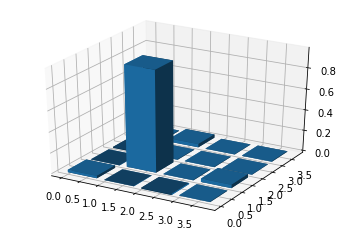

In [294]:
pi_process_matrix = gate_tomography(paper_smooth_optimal_control.gate['X'], qiskit_optimal_control.gate, detuning = 0.*MHz)
plot_density_matrix(pi_process_matrix)

Job Status: job has successfully run
[[0.03515625+0.j         0.046875  +0.02636719j]
 [0.046875  -0.02636719j 0.96484375+0.j        ]]
[[ 0.97265625+0.j        -0.01074219-0.0859375j]
 [-0.01074219+0.0859375j  0.02734375+0.j       ]]
[[0.56835938+0.j         0.46875   +0.13183594j]
 [0.46875   -0.13183594j 0.43164062+0.j        ]]
[[ 0.5546875 +0.j         -0.11621094+0.44335938j]
 [-0.11621094-0.44335938j  0.4453125 +0.j        ]]


C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\optimize.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = df
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\lbfgsb.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  isave, dsave, maxls)
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:2428: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


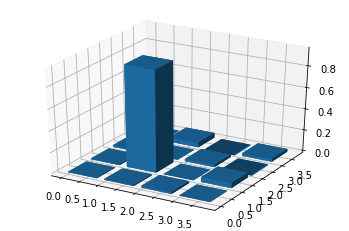

In [295]:
pi_process_matrix = gate_tomography(paper_smooth_optimal_control.gate['X'], paper_smooth_optimal_control.gate, detuning = 0.*MHz)
plot_density_matrix(pi_process_matrix)

Job Status: job has successfully run
[[0.12109375+0.j         0.32714844+0.00097656j]
 [0.32714844-0.00097656j 0.87890625+0.j        ]]
[[ 0.97949219+0.j         -0.02539062+0.02539062j]
 [-0.02539062-0.02539062j  0.02050781+0.j        ]]
[[0.84375   +0.j         0.35546875+0.03417969j]
 [0.35546875-0.03417969j 0.15625   +0.j        ]]
[[ 0.56640625+0.j         -0.06933594+0.46191406j]
 [-0.06933594-0.46191406j  0.43359375+0.j        ]]


C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\optimize.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = df
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\lbfgsb.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  isave, dsave, maxls)
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:2428: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


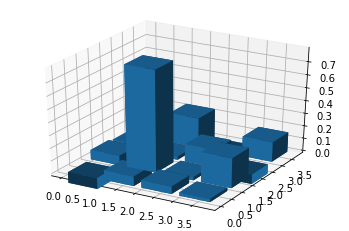

In [296]:
pi_process_matrix = gate_tomography(paper_smooth_optimal_control.gate['X'], paper_smooth_optimal_control.gate, detuning = 1.*MHz)
plot_density_matrix(pi_process_matrix)

Job Status: job has successfully run
[[0.12402344+0.j         0.40332031-0.17285156j]
 [0.40332031+0.17285156j 0.87597656+0.j        ]]
[[ 0.95800781+0.j     -0.1875    +0.3125j]
 [-0.1875    -0.3125j  0.04199219+0.j    ]]
[[0.89941406+0.j         0.10351562+0.02929688j]
 [0.10351562-0.02929688j 0.10058594+0.j        ]]
[[ 0.71484375+0.j         -0.07421875+0.45800781j]
 [-0.07421875-0.45800781j  0.28515625+0.j        ]]


C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\optimize.py:705: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = df
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\lbfgsb.py:338: ComplexWarning: Casting complex values to real discards the imaginary part
  isave, dsave, maxls)
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:2428: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
C:\Users\jhhop\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


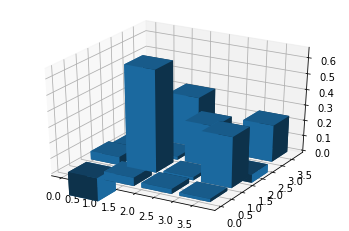

In [297]:
pi_process_matrix = gate_tomography(paper_smooth_optimal_control.gate['X'], paper_smooth_optimal_control.gate, detuning = 3.*MHz)
plot_density_matrix(pi_process_matrix)